In [1]:
import cv2
from PIL import Image
import numpy as np
import uuid
import os
from tqdm import tqdm
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

In [2]:
df = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"/dataset/Video Information Extraction.csv")

In [3]:
df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
0,25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,385,37,885,720,book
1,25,-1,1,10,31,signschool,train,https://signstock.blob.core.windows.net/signsc...,0,7069,462,44,949,720,book
2,25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,7068,234,17,524,414,book
3,25,-1,1,22,59,asldeafined,train,https://media.asldeafined.com/vocabulary/14666...,0,7070,131,26,526,480,book
4,25,-1,1,24,12,aslsearch,val,http://www.aslsearch.com/signs/videos/book.mp4,0,7099,162,54,528,400,book
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11975,25,-1,1,5,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/5/5233.mp4,0,63047,39,13,248,192,wheelchair
11976,25,-1,1,8,12,aslsearch,train,http://www.aslsearch.com/signs/videos/wheelcha...,0,63050,163,62,625,400,wheelchair
11977,25,-1,1,2,2,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/9...,0,63186,76,17,236,240,whistle
11978,25,-1,1,4,11,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/9/9961.mp4,0,63188,68,14,212,192,whistle


### First of all, for a simple use case, only the N most represented  words will be used.

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

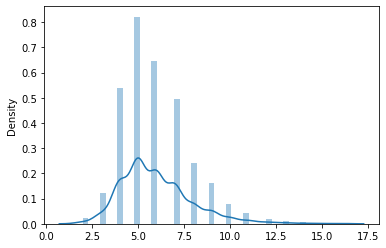

In [4]:
word_freq = dict(df["gloss"].value_counts())
freq = np.array(list(word_freq.values()))

sns.distplot(freq)

In [5]:
print("By taking only word that appears more than 9 times, " + str(len(freq[freq >= 9])) + "will remain ("+str(len(freq[freq < 9])/len(freq))+"% of videos neglected)" )

By taking only word that appears more than 9 times, 204will remain (0.898% of videos neglected)


In [6]:
kept_gloss = list(word_freq.keys())[:np.where(freq < 9)[0][0]]
new_df = df[df["gloss"].isin(kept_gloss)]

In [7]:
new_df = new_df.sort_values(by='video_id')

In [8]:
new_df

,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,gloss
565,25,-1,1,12,26,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/1...,1,623,54,6,272,240,accident
556,25,-1,1,2,29,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/7...,0,624,42,6,278,240,accident
557,25,-1,1,3,6,signschool,test,https://signstock.blob.core.windows.net/signsc...,1,625,675,50,1461,1080,accident
558,25,-1,1,4,32,signschool,val,https://signstock.blob.core.windows.net/signsc...,0,626,485,85,1608,1080,accident
559,25,-1,1,5,6,signschool,val,https://signstock.blob.core.windows.net/signsc...,1,627,662,54,1434,1080,accident
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/what.mp4,1,69531,155,34,1067,720,what
537,25,-1,1,1,118,aslbrick,val,http://aslbricks.org/New/ASL-Videos/white.mp4,0,69533,366,40,875,720,white
78,25,-1,1,1,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/who.mp4,0,69534,381,45,868,720,who
1331,25,-1,1,1,115,aslbrick,test,http://aslbricks.org/New/ASL-Videos/write.mp4,0,69544,375,42,940,720,write


### Collect videos as images sequence

#### Open a video with open CV

In [9]:
video_path = os.path.dirname(os.path.dirname(os.getcwd()))+"\\dataset\\videos\\"
id_video = 1652

In [10]:
cap = cv2.VideoCapture(video_path + str(df["video_id"][id_video]).zfill(5)+".mp4")
frame_count = 1

frame_start = df["frame_start"][id_video]
frame_end =  df["frame_end"][id_video]
x1,y1,x2,y2 = df["bbox_xmin"][id_video], df["bbox_ymin"][id_video], df["bbox_xmax"][id_video], df["bbox_ymax"][id_video]
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret :
        if (frame_count >= frame_start) and ((frame_end == -1) or (frame_end >= frame_count)):
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
        cv2.imshow('frame',frame)
    else:
        break
    frame_count += 1
    if cv2.waitKey(20) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

### Create the numpy dataset

In [11]:
def convert_image_numpy(filename) :
    cap = cv2.VideoCapture(filename)
    img = []
    while (cap.isOpened()):
        ret, frame = cap.read()
        
        if ret:
            frame = cv2.resize(frame, (224, 224))
            img.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            break
    cap.release()
    cv2.destroyAllWindows()
    return np.array(img, dtype = np.short)

In [12]:
test_img = convert_image_numpy(video_path + str(new_df["video_id"].iloc[0]).zfill(5)+".mp4")

In [13]:
test_img.shape

(104, 224, 224, 3)

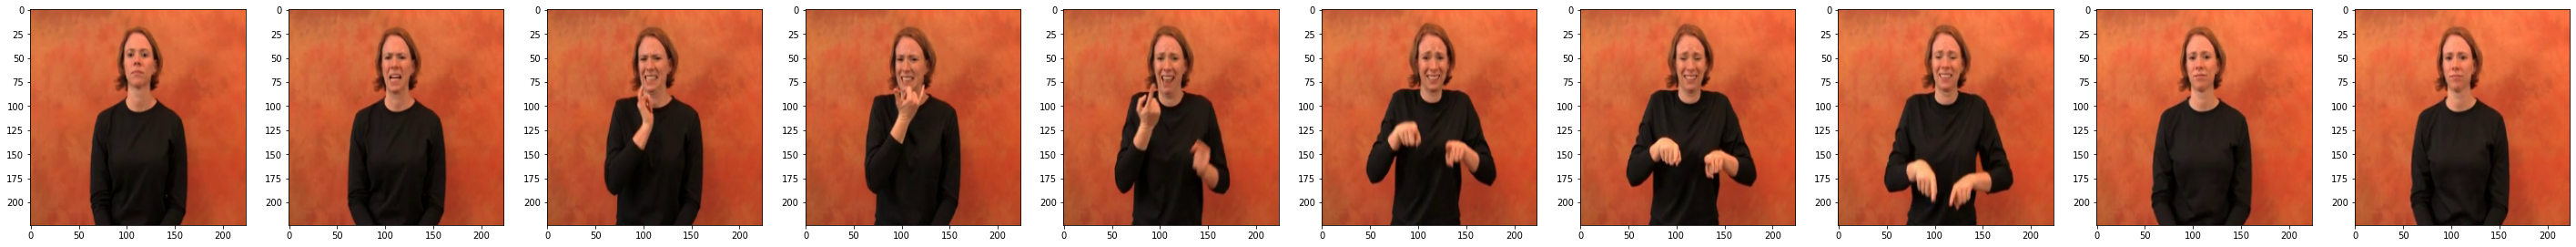

In [14]:
fig, ax = plt.subplots(1,10, figsize = (50,10))
for count, id_seq in enumerate(np.linspace(0,len(test_img)-1, 10, dtype=int)):
    ax[count].imshow(test_img[id_seq])
plt.show()

In [15]:
video_record = {}
for video_id in tqdm(new_df["video_id"]):
    video_record[video_id] = convert_image_numpy(video_path + str(video_id).zfill(5)+".mp4")

100%|██████████████████████████████████████████████████████████████████████████████| 2060/2060 [03:23<00:00, 10.14it/s]


#### Analysing sequence length

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


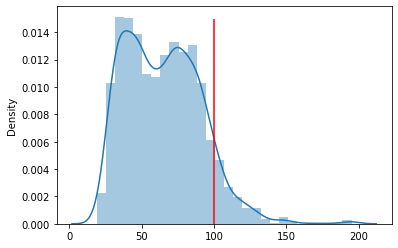

In [16]:
len_sequence_video= np.array([len(seq) for seq in video_record.values()])
sns.distplot(len_sequence_video)
plt.vlines(100, 0, 0.015, 'r')

## Construct all videos with the same number of sequence

Has it will be feed to a deep neural network, we need to have a fixed number of sequence for each record. To do that, a linear interpolation.

In [17]:
number_of_sequences = 64

In [18]:
masks = np.zeros((len(video_record), number_of_sequences), dtype = "bool")

In [19]:
masks.shape

(2060, 64)

In [20]:
mobileNet = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    pooling="avg"
)

In [21]:
mobileNet.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [24]:
clean_record = []
for count, video in tqdm(enumerate(list(video_record.values()))):
    pre_process_video = tf.keras.applications.mobilenet_v3.preprocess_input(video)
    nb_seq = pre_process_video.shape[0]
    if number_of_sequences < nb_seq:
        idx = np.linspace(0, nb_seq-1, number_of_sequences, dtype = int)
        masks[count] = 1
        temp_video = np.take(pre_process_video, idx, axis = 0)
        features = mobileNet.predict(temp_video, verbose = 0).reshape(number_of_sequences, 576)
    else:
        masks[count,:nb_seq] = 1
#         temp_video = np.concatenate((video, np.zeros((number_of_sequences - nb_seq, 224, 224, 3), dtype = np.short)), axis = 0)
        features = mobileNet.predict(pre_process_video, verbose = 0).reshape(nb_seq, 576)
        features = np.concatenate((features, np.zeros((number_of_sequences - nb_seq, 576), dtype = np.short)), axis = 0)

    if features.shape != (number_of_sequences, 576):
        print("Problem")
        break    
    clean_record.append(features)

2060it [12:54,  2.66it/s]


In [25]:
skf = StratifiedKFold(n_splits=2)
skf2 = StratifiedKFold(n_splits=2)
train_index, test_index = skf.split(clean_record, list(new_df["gloss"]))
train_index = train_index[0]
test_index = test_index[0]

df_split1 = new_df.iloc[train_index]
df_split2 = new_df.iloc[test_index]

train_index2, test_index2 = skf2.split([clean_record[i] for i in train_index], list(df_split1["gloss"]))
fold1 = df_split1.iloc[train_index2[0]]["video_id"]
fold2 = df_split1.iloc[test_index2[0]]["video_id"]

train_index2, test_index2 = skf2.split([clean_record[i] for i in test_index], list(df_split2["gloss"]))
fold3 = df_split2.iloc[train_index2[0]]["video_id"]
fold4 = df_split2.iloc[test_index2[0]]["video_id"]

index_video_id = list(new_df["video_id"])

fold1 = [index_video_id.index(video_id) for video_id in fold1]
fold2 = [index_video_id.index(video_id) for video_id in fold2]
fold3 = [index_video_id.index(video_id) for video_id in fold3]
fold4 = [index_video_id.index(video_id) for video_id in fold4]

In [26]:
for num_fold, fold in enumerate([fold1, fold2, fold3, fold4]):
    joblib.dump([clean_record[i] for i in fold], 'Kfold/features/' + str(num_fold) + '.pkl', compress = 3)
    joblib.dump(np.take(masks, fold, axis = 0), 'Kfold/Masks/' + str(num_fold) + '.pkl', compress = 3)
    new_df.iloc[fold].to_csv('Kfold/Dataframe/' + str(num_fold)+'.csv')

In [27]:
reduced_encoder = OneHotEncoder(handle_unknown='ignore')
reduced_encoder.fit(np.array(list(new_df["gloss"])).reshape(-1,1))

reduced_le = LabelEncoder()
reduced_le.fit(np.array(list(new_df["gloss"])))

LabelEncoder()

In [28]:
pickle.dump(reduced_encoder, open("reduced one hot encoder", 'wb'))
pickle.dump(reduced_le, open("reduced label encoder", 'wb'))